# XAI MODEL BUILD

In [3]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [4]:
df_train = pd.read_csv('../2_Modeling-Phase/train_and_test_datasets/train_XGB.csv')
df_test = pd.read_csv('../2_Modeling-Phase/train_and_test_datasets/test_XGB.csv')

In [5]:
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [6]:
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

## Load Model

In [7]:
# Save the trained model to a specific folder
model_folder = "../3_Post-Modeling-Phase/Models/"
model_filename = "NSL-KDD_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

## Feature Importance

In [8]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

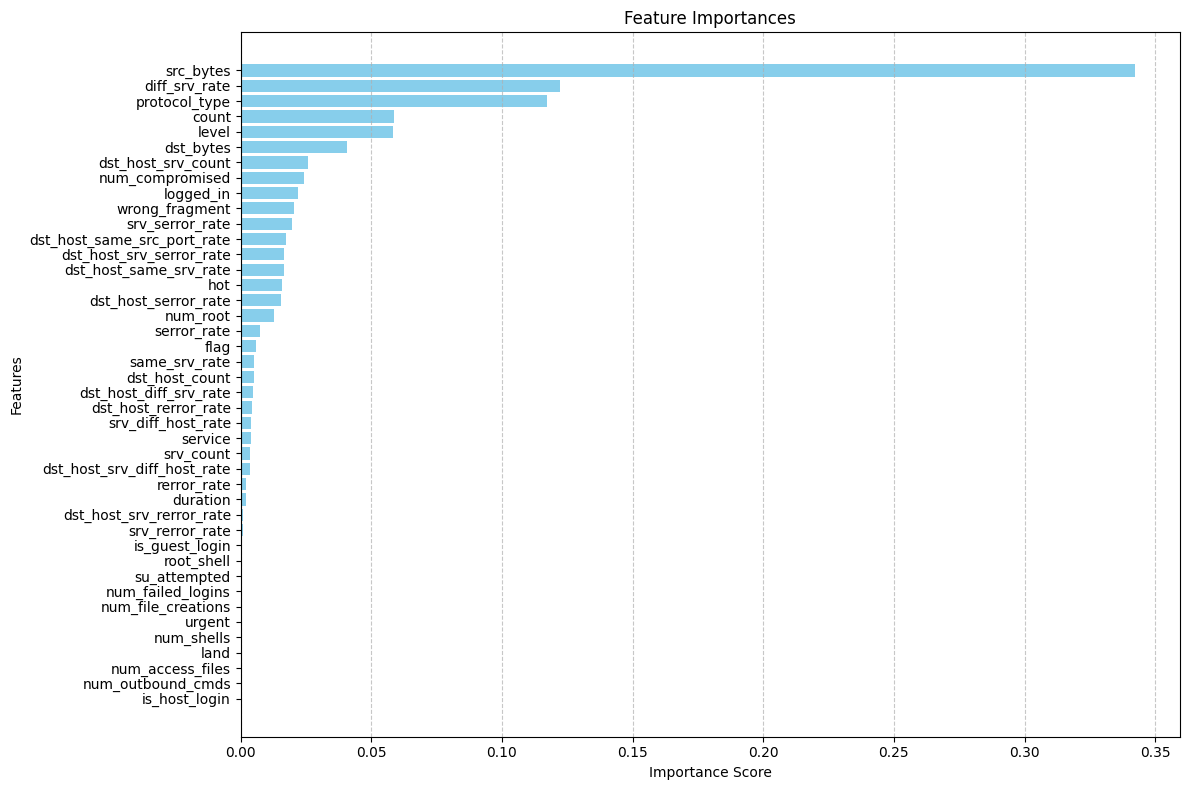

In [9]:

importances = model.feature_importances_


indices = np.argsort(importances)[::-1]


fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

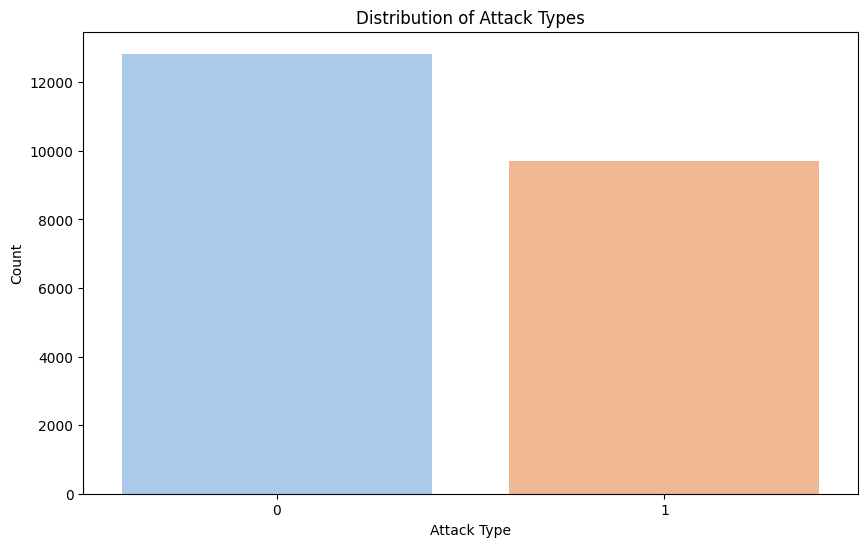

In [10]:
# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, palette="pastel")

# Add labels and title
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types")

# Show the plot
plt.show()

## MODELS

In [11]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 7.23 ms, sys: 3.44 ms, total: 10.7 ms
Wall time: 19.2 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,src_bytes,4,0.342388,1.000000
1,diff_srv_rate,29,0.122204,0.976190
2,protocol_type,1,0.117225,0.952381
3,count,22,0.058834,0.928571
4,level,41,0.058354,0.904762
5,dst_bytes,5,0.040676,0.880952
6,dst_host_srv_count,32,0.025645,0.857143
7,num_compromised,12,0.024098,0.833333
8,logged_in,11,0.021875,0.809524
9,wrong_fragment,7,0.020307,0.785714


## Morris Sensitivity Analysis

In [12]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

CPU times: user 4.91 s, sys: 452 ms, total: 5.36 s
Wall time: 939 ms
                                    0
protocol_type                0.315327
level                        0.264834
dst_host_rerror_rate         0.197127
dst_host_srv_serror_rate     0.168865
dst_host_same_srv_rate       0.109144
src_bytes                    0.088389
dst_host_srv_count           0.075968
service                      0.075841
dst_host_srv_rerror_rate     0.066732
dst_host_serror_rate         0.056769
dst_host_count               0.051192
dst_bytes                    0.048806
dst_host_same_src_port_rate  0.047686
dst_host_diff_srv_rate       0.043990
flag                         0.043596
count                        0.043453
serror_rate                  0.043388
wrong_fragment               0.043189
srv_count                    0.038386
same_srv_rate                0.037431
duration                     0.033323
hot                          0.031527
srv_serror_rate              0.029153
dst_host_srv_diff_h

<!-- http://127.0.0.1:7001/5344427920/ -->

## LOFO IMPORTANCE

In [13]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance


/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2855
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2858
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2858
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2886
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429797 -> initscore=-0.282681
[LightGBM] [Info] Start training from score -0.282681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
10,level,4.372459e-04,0.000130,3.730332e-04,5.300434e-04,0.000257,0.000588
26,dst_host_srv_diff_host_rate,4.002997e-05,0.000064,3.219689e-06,-7.691077e-07,0.000152,0.000006
4,service,3.045421e-05,0.000056,1.957571e-05,4.358277e-06,0.000123,-0.000025
1,dst_host_same_srv_rate,2.815552e-05,0.000056,6.439379e-07,-6.665600e-06,0.000126,-0.000007
23,dst_host_srv_serror_rate,1.610205e-05,0.000035,-3.348477e-06,5.127385e-07,0.000076,-0.000009
9,dst_host_serror_rate,1.268275e-05,0.000016,3.863627e-07,-5.127385e-07,0.000040,0.000011
25,dst_host_srv_count,1.011338e-05,0.000017,-5.022716e-06,1.358757e-05,0.000037,-0.000005
16,logged_in,1.010080e-05,0.000023,4.378778e-06,-1.410031e-06,0.000049,-0.000011
21,srv_diff_host_rate,6.638305e-06,0.000023,4.765140e-06,-4.871016e-06,0.000044,-0.000017
18,flag,6.435331e-06,0.000014,5.022716e-06,6.409231e-07,0.000029,-0.000009


## SHAP EXPLAINABILITY

100%|===================| 22535/22544 [12:21<00:00]        

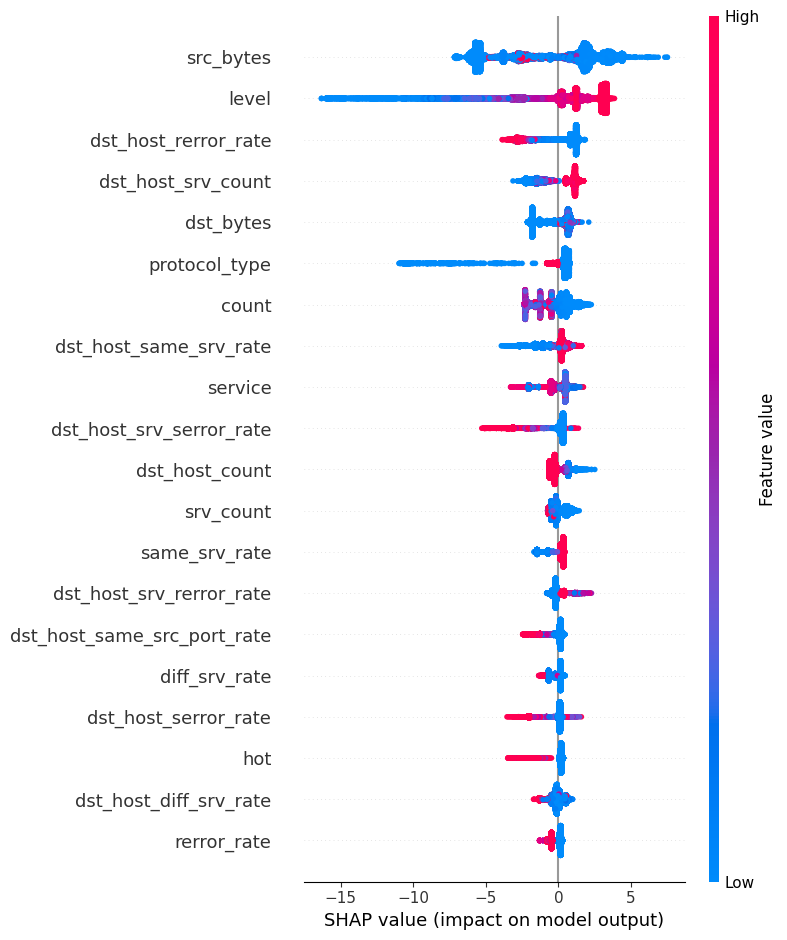

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [20]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test)

# Get SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot (for individual predictions)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

## LIME EXPLAINABILITY

/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/mohammedabdulai/anaconda3/

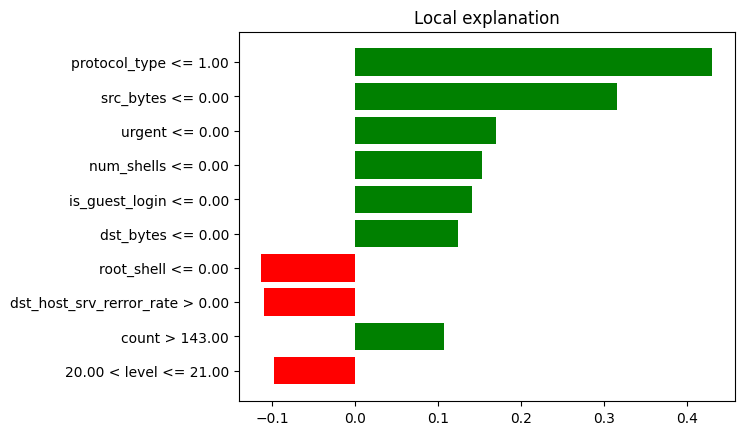

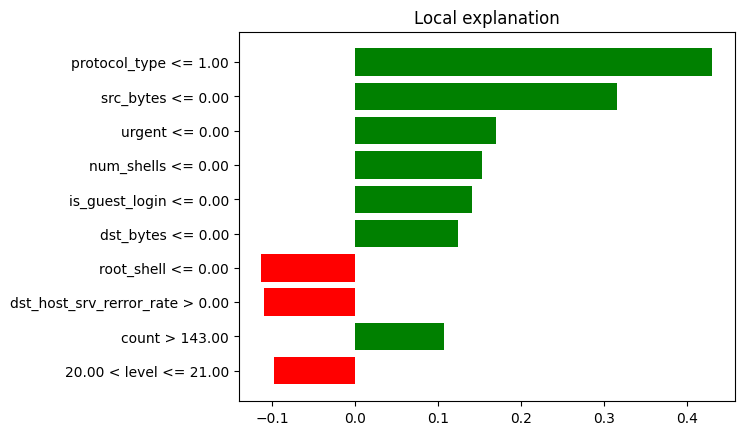

In [14]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),  # Training data as a NumPy array
    feature_names=X_train.columns,   # Feature names
    class_names=['Class 0', 'Class 1'],  # Replace with your model's class labels
    mode='regression'            # Use 'regression' for regression models
)

# Pick a test instance to explain
test_instance = X_test.iloc[0]

# Explain the prediction for the selected test instance
lime_explanation = lime_explainer.explain_instance(
    data_row=test_instance,         # The test instance to explain
    predict_fn=model.predict_proba  # Prediction function (returns probabilities)
)

# Show the explanation in a human-readable format
lime_explanation.show_in_notebook(show_table=True)

# Visualize LIME explanation as a chart
lime_explanation.as_pyplot_figure()
